<a id='top'></a>

# Expected Goals Models with Wyscout Event Data
##### Notebook to create an Expected Goals (xG) model using a full season of publicly available [Wyscout](https://wyscout.com/) Event data

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 26/01/2021<br>
Notebook last updated: 31/01/2021

![title](../../../img/expected_goals_visual.png)

---

## <a id='import_libraries'>Introduction</a>
This notebook is a short walk-through of how to create an Expected Goals (xG) model using a season's worth of [Wyscout](https://wyscout.com/) Event data for the 'Big 5' European leagues, in [Python](https://www.python.org/), using [pandas](http://pandas.pydata.org/) DataFrames, [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/TransferMarkt%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
5.    [Feature Engineering](#section5)<br>
6.    [Machine Learning Modelling](#section6)<br>
7.    [Model Evaluation](#section7)<br>
8.    [Summary](#section8)<br>
9.    [Next Steps](#section9)<br>
10.    [Bibliography](#section10)<br>

---

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) for web scraping; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [50]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm    # Progress Bar

# Football libraries
import FCPython
#from FCPython import createPitch
import matplotsoccer
import socceraction.classification.features as features
import socceraction.classification.labels as labels
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep import value

# Machine Learning
import scipy as sp
from scipy.spatial import distance
from sklearn.metrics import brier_score_loss, roc_auc_score    # version 0.22
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc_curve
from scikitplot.metrics import plot_precision_recall_curve
from scikitplot.metrics import plot_calibration_curve
from xgboost import XGBClassifier   # version 1.0.2
import catboost    # pip install catboost if you don't have it
from catboost import CatBoostClassifier, Pool, cv

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.0
pandas: 1.2.0
matplotlib: 3.3.2
Seaborn: 0.11.1


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [4]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_wyscout = os.path.join(base_dir, 'data', 'wyscout')
scripts_dir = os.path.join(base_dir, 'scripts')
scripts_dir_wyscout = os.path.join(base_dir, 'scripts', 'wyscout')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_dir_wyscout = os.path.join(base_dir, 'img', 'fig', 'wyscout')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [5]:
# Define custom function to read JSON files that also handles the encoding of special characters e.g. accents in names of players and teams
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [6]:
def draw_pitch(pitch, line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

### Notebook Settings

In [7]:
pd.set_option('display.max_columns', None)

---

## <a id='#section2'>2. Project Brief</a>

### <a id='#section2.1'>2.1. About this notebook</a>
This notebook creates an Expected Goals (xG) model using a the [publicly available 17/18 season of Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000) for the 'Big 5' European leagues to create a basic Expected Goals (xG) model, using [pandas](http://pandas.pydata.org/) DataFrames, [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

**References**:<br>
This notebook uses the SPADL representation by SciSports, which is introduced in more detail in the following paper by [Tom Decroos](https://twitter.com/TomDecroos), [Lotte Bransen](https://twitter.com/LotteBransen), [Jan Van Haaren](https://twitter.com/JanVanHaaren), and [Jesse Davis](https://twitter.com/jessejdavis1). **[Actions Speak Louder than Goals: Valuing Player Actions in Soccer](https://arxiv.org/abs/1802.07127)**. In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.

This notebook also uses Wyscout data, made publicly available in the following paper by Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. **[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)**. In *Scientific Data 6*, no. 1 (2019): 1-15.

### <a id='#section2.2'>2.2. What is xG?</a>
["Expected goals"](https://en.wikipedia.org/wiki/Expected_goals) or more commonly known as 'xG', is a dervied football metric, which allows you to evaluate team and player performance. In a low-scoring game such as football, final match score does not provide a clear picture of performance. More and more professional clubs and sports analytics teams are now turning to the advanced models like xG, which is a statistical measure of the quality of chances created and conceded.

As a metric, xG assesses every chance, essentially answering the question of whether a player should have scored from a certain opportunity. Put simply, it is a way of assigning a "quality" value (xG) to every attempt based on what we know about it. The higher the xG - with 1 being the maximum - the more likelihood of the opportunity being taken. So if a chance is 0.5xG, it should be scored 50% of the time.

xG was created by [Sam Green](https://twitter.com/aSamGreen) from [Opta](https://www.optasports.com/) after analysing over 300,000 shots to calculate the likelihood of an attempt being scored from a specific position on the pitch during a particular phase of play.

The factors taken into account when assessing the quality of a chance include:
*    Distance from goal
*    Angle of the shot
*    Did the chance fall at the player's feet or was it a header?
*    Was it a one on one?
*    What was the assist like? (eg long ball, cross, through ball, pull-back)
*    In what passage of play did it happen? (eg open play, direct free-kick, corner kick)
*    Has the player just beaten an opponent?
*    Is it a rebound?

The expected goals value reveals a number of things including:
*    Whether a chance really is as good as we think. While football is still a game that where debate and opinion make a huge part of the build up and analysis of matches, using xG we can now say with some certainty whether an opportunity should have been taken.
*    How many goals an individual player should be scoring from the chances their have. A striker might be top of the scoring charts, but does that necessarily mean he is the best finisher in the league? Previously we might have simply looked at their conversion rate (how many of their chances ended up as goals), but this did not provide the whole picture, as someone with a high conversion rate might just be the beneficiary of their team creating really clear-cut chances.
*    Team performance. If a team is performing above or below expectations at the start of the new season, a look at their expected goals difference could tell you whether that run is likely to last.

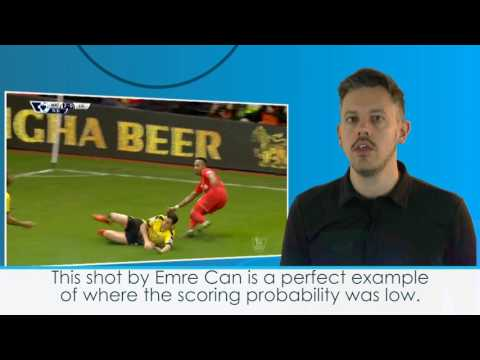

In [8]:
YouTubeVideo('w7zPZsLGK18')

---

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>

#### <a id='#section3.1.1'>3.1.1. About Wyscout</a>
[Wyscout](https://wyscout.com/) is an Italian company that supports football scouting, match analysis and transfer dynamics. The company was founded in Genoa, Italy in 2004 and provides video analysis tools and digital databases regarding performances and matches for coaches, teams and players dealing with football business.

![title](../../../img/wyscout_logo.png)

The purpose is to allow them have a detailed sight of a large number of athletes about individual performances, patterns of play and tactical strategy.

This notebook explores a complete dataset of event data for the Big 5 European leagues during the 17/18 season.

#### <a id='#section3.1.2'>3.1.2. About the Wyscout publicly available data</a>
A detailed description of the data can be found in the following paper:
- Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

It is from this paper import the *matches*, *events*, *players*, *playerank*, *referees*, *coaches*, and *competition* data sets from the <a href="https://doi.org/10.6084/m9.figshare.c.4415000.v5">figshare repository</a>. Data are stored in the `JSON` format. 

The complete data set contains:
- 1,941 matches
- 3,251,294 events
- 4,299 players.

The datasets we will be using are:
- competitions;
- events;
- matches;
- players; and
- teams

Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

### <a id='#section3.2'>3.2. Download the data</a>
This section downloads the Wyscout datasets, collates the required information about the match events, and converts the match events into the SPADL representation. This process is as follows:
1. Download the Wyscout dataset;
2. Construct an HDF5 file named `wyscout.h5` that contains the relevant information from the dataset;
3. Convert the `wyscout.h5` file into a `spadl.h5` file that contains the same information in the SPADL representation.

**Note**: The [`socceraction`](https://github.com/ML-KULeuven/socceraction) library offers off-the-shelf functionality to convert a collection of Wyscout JSON files into the SPADL representation. However, the JSON files in the publicly available dataset are not directly compatible with the `socceraction` functionality. Therefore, we need to perform a few additional steps to transform the Wyscout data into the SPADL representation.

The following `data_files` dictionary lists the four data files in the Wyscout dataset that are required to run the VAEP framework.
*    `events` (73.74 MB): match events for the matches in the dataset;
*    `matches` (629.98 kB): overview of the matches in the dataset;
*    `players` (1.66 MB): information on the players in the dataset;
*    `teams` (26.76 kB): information on the teams in the dataset.

In [9]:
# Define dict in Python where the keys are the names of the files and the values are the corresponding URLs
data_files = {'events': 'https://ndownloader.figshare.com/files/14464685',     # ZIP file containing one JSON file for each competition
              'matches': 'https://ndownloader.figshare.com/files/14464622',    # ZIP file containing one JSON file for each competition
              'players': 'https://ndownloader.figshare.com/files/15073721',    # JSON file
              'teams': 'https://ndownloader.figshare.com/files/15073697'       # JSON file
             }

The following cell loops through the `data_files` dictionary, downloads each listed data file if it is not already present in the directory, and stores each downloaded data file to the local file system.

If the downloaded data file is a ZIP archive, the included JSON files are extracted from the ZIP archive and stored to the local file system.

In [10]:
# Download the listed data files for events, matches, players, and teams
if not os.path.exists(data_dir_wyscout + '/raw/json/'):
    for url in tqdm(data_files.values()):
        url_s3 = urlopen(url).geturl()
        path = Path(urlparse(url_s3).path)
        file_name = path.name
        file_local, _ = urlretrieve(url_s3, file_name)
        if is_zipfile(file_local):
            with ZipFile(file_local) as zip_file:
                zip_file.extractall()
else:
    pass    

### <a id='#section3.3'>3.3. Read in Data</a>
The following cells read the the JSON files into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `players`.

####  <a id='#section3.3.1.'>3.3.1. Teams</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON file

In [11]:
# Read JSON file as a JSON string and create a pandas DataFrame form the resulting JSON string
json_teams = read_json_file(data_dir_wyscout + '/raw/json/' + 'teams.json')
df_teams = pd.read_json(json_teams)

In [12]:
# Display DataFrame
df_teams.head(10)

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
5,Troyes,Troyes,3795,Espérance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
6,Getafe (Madrid),Getafe,698,Getafe Club de Fútbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
7,Mönchengladbach,Borussia M'gladbach,2454,Borussia VfL Mönchengladbach,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
9,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


####  <a id='#section3.3.2.'>3.3.2. Players</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON file

In [13]:
# Read JSON file as a JSON string and create a pandas DataFrame form the resulting JSON string
json_players = read_json_file(data_dir_wyscout + '/raw/json/' + 'players.json')
df_players = pd.read_json(json_players)

In [14]:
# Display DataFrame
df_players.head(10)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null
5,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",83,Jasper,,Cillessen,676,1989-04-22,185,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",33,right,J. Cillessen,664
6,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",91,Toby,,Alderweireld,1624,1989-03-02,187,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",36,right,T. Alderweireld,5629
7,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",88,Jan,,Vertonghen,1624,1987-04-24,189,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",48,left,J. Vertonghen,5629
8,"{'name': 'France', 'id': '250', 'alpha3code': ...",74,Alexander,,Djiku,3783,1994-08-09,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",229427,right,A. Djiku,null
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712


####  <a id='#section3.3.3.'>3.3.3. Matches</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Define Competitions
The following cell lists the competitions to be included in the dataset. Dataset includes data for seven different competitions - 5 domestic and 2 international.

In [15]:
# Define a list to select only the competitions of interest. 
# For this Expected Goals model, I will use all the data available

# Define list of competitions
competitions = ['England',
                'France',
                'Germany',
                'Italy',
                'Spain',
                'European Championship',
                'World Cup'
               ]

##### Read JSON files
The following cells read the `matches.json` files for the selected competitions into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `matches`.

In [16]:
# Loop through the competition files for the selected competition(s)
# Take the separate JSON files each representing a match for the selected competition(s).
# The file is called matches_{competition_name}.json.
# Read the corresponding JSON matches files using the auxillary function
# Read JSON file as a pandas DataFrame
# Append the DataFrames to a list
# Finally, concatenate all the separate DataFrames into one DataFrame

## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(data_dir_wyscout + '/raw/json/matches/' + file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)

In [17]:
# Display DataFrame
df_matches.head(10)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId,groupName
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364,NaN
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364,NaN
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,NaN
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364,NaN
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364,NaN
5,Played,4405654,38,"{'1613': {'scoreET': 0, 'coachId': 210700, 'si...",181150,2018-05-13 14:00:00,1613,St. James' Park,2500094,"Newcastle United - Chelsea, 3 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384888, 'role': 'referee'}, {'r...",Regular,364,NaN
6,Played,4405654,38,"{'1625': {'scoreET': 0, 'coachId': 267136, 'si...",181150,2018-05-13 14:00:00,1625,St. Mary's Stadium,2500095,"Southampton - Manchester City, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385911, 'role': 'referee'}, {'r...",Regular,364,NaN
7,Played,4405654,38,"{'10531': {'scoreET': 0, 'coachId': 32573, 'si...",181150,2018-05-13 14:00:00,1639,Liberty Stadium,2500096,"Swansea City - Stoke City, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 378952, 'role': 'referee'}, {'r...",Regular,364,NaN
8,Played,4405654,38,"{'1631': {'scoreET': 0, 'coachId': 209010, 'si...",181150,2018-05-13 14:00:00,1624,Wembley Stadium,2500097,"Tottenham Hotspur - Leicester City, 5 - 4","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 378951, 'role': 'referee'}, {'r...",Regular,364,NaN
9,Played,4405654,38,"{'1623': {'scoreET': 0, 'coachId': 8541, 'side...",181150,2018-05-13 14:00:00,1633,London Stadium,2500098,"West Ham United - Everton, 3 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 408156, 'role': 'referee'}, {'r...",Regular,364,NaN


####  <a id='#section3.3.4.'>3.3.4. Events</a>
The following cells read the `events.json` files for the selected competitions into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `events/match_<match-id>`.

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON files

In [18]:
# Loop through the competitions selected
# Read the corresponding events JSON files using the auxillary function
# Read JSON file as a pandas DataFrame
# Group the match events by match_id such that we end up with a separate DataFrame for each individual match
# Loop through each of the match DataFrames and read JSON file as a pandas DataFrame
# Append the DataFrames to a list
# Finally, concatenate all the separate DataFrames into one DataFrame

## Create empty list for DataFrames
dfs_events = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_events list
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(data_dir_wyscout + '/raw/json/events/' + file_events)
    df_events = pd.read_json(json_events)
    dfs_events.append(df_events)
    #df_events_matches = df_events.groupby('matchId', as_index=False)

## Concatenate DataFrames to one DataFrame
df_events = pd.concat(dfs_events)

In [19]:
df_events

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
101754,8,Simple pass,[{'id': 1801}],3476,"[{'y': 20, 'x': 46}, {'y': 6, 'x': 64}]",2058017,Pass,9598,2H,2978.301867,85,263885652
101755,7,Touch,[],14812,"[{'y': 6, 'x': 64}, {'y': 2, 'x': 82}]",2058017,Others on the ball,9598,2H,2979.084611,72,263885653
101756,8,Cross,"[{'id': 401}, {'id': 801}, {'id': 1802}]",14812,"[{'y': 2, 'x': 82}, {'y': 100, 'x': 100}]",2058017,Pass,9598,2H,2983.448628,80,263885654
101757,4,Goalkeeper leaving line,[],25381,"[{'y': 0, 'x': 0}, {'y': 98, 'x': 18}]",2058017,Goalkeeper leaving line,4418,2H,2985.869275,40,263885613


####  <a id='#section3.3.5'>3.3.5 Competitions</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON file

In [20]:
# Read JSON file as a JSON string and create a pandas DataFrame form the resulting JSON string
json_competitions = read_json_file(data_dir_wyscout + '/raw/json/' + 'competitions.json')
df_competitions = pd.read_json(json_competitions)

In [21]:
# Display DataFrame
df_competitions.head(10)

,name,wyId,format,area,type
0,Italian first division,524,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club
1,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,Spanish first division,795,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,French first division,412,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
4,German first division,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
5,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international
6,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international


### <a id='#section3.4'>3.4. Join Datasets</a>
Next, we're required to join the `Matches` DataFrame and the `Players` DataFrame to the `Events` DatFrame. The `Events` data is the base DataFrame in which we join the other tables via `wyId`, `matchId`, `competitionId`, `playerId`, and `teamId`.

##### Join Matches DataFrame to Events DataFrame

In [22]:
# Join the Events DataFrame to the Matches DataFrame
df_wyscout_merge = pd.merge(df_events, df_matches, left_on='matchId', right_on='wyId')

##### Join Competitions DataFrame to Merged DataFrame via Events DataFrame

In [23]:
# Join the Competitions DataFrame to the Events-Matches DataFrame
df_wyscout_merge = pd.merge(df_wyscout_merge, df_competitions, left_on='competitionId', right_on='wyId')

##### Join Players DataFrame to Merged DataFrame via Events DataFrame

In [24]:
# Join the Players DataFrame to the Events-Matches DataFrame
df_wyscout_merge = pd.merge(df_wyscout_merge, df_players, left_on='playerId', right_on='wyId')

##### Join Teams DataFrame to Merged DataFrame via Events DataFrame

In [25]:
# Join the Players DataFrame to the Events-Matches DataFrame
df_wyscout_merge = pd.merge(df_wyscout_merge, df_teams, left_on='teamId', right_on='wyId')

In [26]:
# Display DataFrame
df_wyscout_merge.head(10)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,groupName,name_x,wyId_y,format,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId_x,foot,shortName,currentNationalTeamId,city,name_y,wyId_y,officialName,area_y,type_y
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",2499719,Duel,1609,1H,22.551816,10,177959181,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
3,8,Head pass,[{'id': 1802}],25413,"[{'y': 70, 'x': 71}, {'y': 63, 'x': 71}]",2499719,Pass,1609,1H,397.881307,82,177959276,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
4,1,Ground defending duel,"[{'id': 503}, {'id': 701}, {'id': 1802}]",25413,"[{'y': 64, 'x': 61}, {'y': 87, 'x': 51}]",2499719,Duel,1609,1H,494.461238,12,177959303,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stad

In [27]:
df_wyscout_merge.shape

(3025256, 52)

### <a id='#section3.5'>3.5. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [28]:
# Display the first 5 rows of the raw DataFrame, df_wyscout_merge
df_wyscout_merge.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,groupName,name_x,wyId_y,format,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId_x,foot,shortName,currentNationalTeamId,city,name_y,wyId_y,officialName,area_y,type_y
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",2499719,Duel,1609,1H,22.551816,10,177959181,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
3,8,Head pass,[{'id': 1802}],25413,"[{'y': 70, 'x': 71}, {'y': 63, 'x': 71}]",2499719,Pass,1609,1H,397.881307,82,177959276,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
4,1,Ground defending duel,"[{'id': 503}, {'id': 701}, {'id': 1802}]",25413,"[{'y': 64, 'x': 61}, {'y': 87, 'x': 51}]",2499719,Duel,1609,1H,494.461238,12,177959303,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stad

In [29]:
# Display the last 5 rows of the raw DataFrame, df_wyscout_merge
df_wyscout_merge.tail()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,groupName,name_x,wyId_y,format,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId_x,foot,shortName,currentNationalTeamId,city,name_y,wyId_y,officialName,area_y,type_y
3025251,8,Simple pass,[{'id': 1801}],116293,"[{'y': 72, 'x': 30}, {'y': 64, 'x': 42}]",2057995,Pass,17929,2H,2242.045496,85,260874786,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,Group G,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",84,Harold Oshkaly,,Cummings Segura,7851,1992-03-01,180,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",116293,right,H. Cummings,17929,Ciudad de Panamá,Panama,17929,Panama,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",national
3025252,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",116293,"[{'y': 73, 'x': 37}, {'y': 48, 'x': 28}]",2057995,Duel,17929,2H,2501.224726,11,260874815,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,Group G,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",84,Harold Oshkaly,,Cummings Segura,7851,1992-03-01,180,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",116293,right,H. Cummings,17929,Ciudad de Panamá,Panama,17929,Panama,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",national
3025253,1,Air duel,"[{'id': 701}, {'id': 1802}]",116293,"[{'y': 70, 'x': 33}, {'y': 81, 'x': 23}]",2057995,Duel,17929,2H,2693.694869,10,260874832,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,Group G,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",84,Harold Oshkaly,,Cummings Segura,7851,1992-03-01,180,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",116293,right,H. Cummings,17929,Ciudad de Panamá,Panama,17929,Panama,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",national
3025254,8,Simple pass,[{'id': 1801}],116293,"[{'y': 52, 'x': 39}, {'y': 33, 'x': 39}]",2057995,Pass,17929,2H,2784.257941,85,260874843,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,Group G,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",84,Harold Oshkaly,,Cummings Segura,7851,1992-03-01,180,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",116293,right,H. Cummings,17929,Ciudad de Panamá,Panama,17929,Panama,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",national
3025255,8,High pass,[{'id': 1802}],116293,"[{'y': 65, 'x': 35}, {'y': 82, 'x': 69}]",2057995,Pass,17929,2H,2792.161774,83,260874845,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,

In [30]:
# Print the shape of the raw DataFrame, ddf_wyscout_merge
print(df_wyscout_merge.shape)

(3025256, 52)


In [31]:
# Print the column names of the raw DataFrame, df_wyscout_merge
print(df_wyscout_merge.columns)

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id',
       'status', 'roundId', 'gameweek', 'teamsData', 'seasonId', 'dateutc',
       'winner', 'venue', 'wyId_x', 'label', 'date', 'referees', 'duration',
       'competitionId', 'groupName', 'name_x', 'wyId_y', 'format', 'area_x',
       'type_x', 'passportArea', 'weight', 'firstName', 'middleName',
       'lastName', 'currentTeamId', 'birthDate', 'height', 'role', 'birthArea',
       'wyId_x', 'foot', 'shortName', 'currentNationalTeamId', 'city',
       'name_y', 'wyId_y', 'officialName', 'area_y', 'type_y'],
      dtype='object')


The dataset has fifty three features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [32]:
# Data types of the features of the raw DataFrame, df_wyscout_merge
df_wyscout_merge.dtypes

eventId                    int64
subEventName              object
tags                      object
playerId                   int64
positions                 object
matchId                    int64
eventName                 object
teamId                     int64
matchPeriod               object
eventSec                 float64
subEventId                object
id                         int64
status                    object
roundId                    int64
gameweek                   int64
teamsData                 object
seasonId                   int64
dateutc                   object
winner                     int64
venue                     object
wyId_x                     int64
label                     object
date                      object
referees                  object
duration                  object
competitionId              int64
groupName                 object
name_x                    object
wyId_y                     int64
format                    object
area_x    

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [33]:
# Info for the raw DataFrame, df_wyscout_merge
df_wyscout_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025256 entries, 0 to 3025255
Data columns (total 52 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   eventId                int64  
 1   subEventName           object 
 2   tags                   object 
 3   playerId               int64  
 4   positions              object 
 5   matchId                int64  
 6   eventName              object 
 7   teamId                 int64  
 8   matchPeriod            object 
 9   eventSec               float64
 10  subEventId             object 
 11  id                     int64  
 12  status                 object 
 13  roundId                int64  
 14  gameweek               int64  
 15  teamsData              object 
 16  seasonId               int64  
 17  dateutc                object 
 18  winner                 int64  
 19  venue                  object 
 20  wyId_x                 int64  
 21  label                  object 
 22  date              

In [ ]:
# Description of the raw DataFrame, df_wyscout_merge, showing some summary statistics for each numberical column in the DataFrame
df_wyscout_merge.describe()

In [ ]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_wyscout_merge
msno.matrix(df_wyscout_merge, figsize = (30, 7))

In [ ]:
# Counts of missing values
null_value_stats = df_wyscout_merge.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

The visualisation shows us very quickly that there a few missing values in the `value` column, but otherwise the dataset is complete.

---

## <a id='#section4'>4. Data Engineering</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Sort DataFrame</a>

In [61]:
df_wyscout_merge = df_wyscout_merge.sort_values(['matchId', 'matchPeriod', 'eventSec'])

### <a id='#section4.2'>4.2. Create attributes</a>

##### Create `league_name` column derived from the `competition_name_generic` column

In [34]:
dict_league_name_wyscout = {'Italy first division': 'Seria A',
                            'English first division': 'Premier League',
                            'Spanish first division': 'La Liga',
                            'French first division': 'Ligue 1',
                            'German first division': 'Bundesliga',
                            'European Championship': 'UEFA EURO',
                            'World Cup': 'FIFA World Cup'
                           }

In [35]:
#df_wyscout_merge['league_name'] = df_wyscout_merge['competition_name_generic'].map(dict_league_name_wyscout)

##### Create `fullName` attribute 
Join together the `firstName` and `lastName` attribute to create a `fullName` attribute.

In [36]:
df_wyscout_merge['fullName'] = df_wyscout_merge['firstName'].astype(str) + ' ' + df_wyscout_merge['lastName'].astype(str)

In [ ]:
all_events_df['previous_event'] = all_events_df['subEventName'].shift(1)

### <a id='#section4.3'>4.3. Rename columns</a>

In [37]:
df_wyscout_merge = df_wyscout_merge.rename(columns={'name_y': 'teamName'})

### <a id='#section4.4'>4.4. Export DataFrame</a>

In [ ]:
# Export DataFrame as CSV
if not os.path.exists(data_dir_wyscout + '/raw/csv/wyscout_complete.csv'):
    df_wyscout_merge.to_csv(data_dir_wyscout + '/raw/csv/wyscout_complete.csv', index=None, header=True)
else:
    pass

### <a id='#section4.5'>4.5. Streamline DataFrame</a>

In [38]:
# Print the column names of the raw DataFrame, df_wyscout_merge
print(df_wyscout_merge.columns)

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id',
       'status', 'roundId', 'gameweek', 'teamsData', 'seasonId', 'dateutc',
       'winner', 'venue', 'wyId_x', 'label', 'date', 'referees', 'duration',
       'competitionId', 'groupName', 'name_x', 'wyId_y', 'format', 'area_x',
       'type_x', 'passportArea', 'weight', 'firstName', 'middleName',
       'lastName', 'currentTeamId', 'birthDate', 'height', 'role', 'birthArea',
       'wyId_x', 'foot', 'shortName', 'currentNationalTeamId', 'city',
       'teamName', 'wyId_y', 'officialName', 'area_y', 'type_y', 'fullName'],
      dtype='object')


In [ ]:
"""
# Select columns of interest
cols = ['eventId',
        'subEventName',
        'tags',
        'playerId',
        'positions',
        'matchId',
        'eventName',
        'teamId',
        'matchPeriod',
        'eventSec',
        'subEventId',
        'id',
        'status',
        'roundId',
        'gameweek',
        'teamsData',
        'dateutc',
        'winner',
        'venue',
        'wyId_x',
        'label',
        'date',
        'referees',
        'duration',
        'groupName',
        'name_x',
        'format',
        'area_x',
        'type_x',
        'weight',
        'fullName',
        'currentTeamId',
        'birthDate',
        'height',
        'role',
        'birthArea',
        'wyId_x',
        'foot',
        'shortName',
        'currentNationalTeamId',
        'city',
        'teamName',
        'officialName',
        'area_y',
        'type_y',
       ]

# Create more concise DataFrame using only columns of interest
df_wyscout_merge_select = df_wyscout_merge[cols_matches]
"""

In [41]:
# Select columns of interest
cols = ['eventId',
        'subEventName',
        'tags',
        'playerId',
        'positions',
        'matchId',
       'eventName',
        'teamId',
        'matchPeriod',
        'eventSec',
        'subEventId',
        'id'
       ]

# Create more concise DataFrame using only columns of interest
df_wyscout_merge_select = df_wyscout_merge[cols]

In [42]:
df_wyscout_merge_select.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",2499719,Duel,1609,1H,22.551816,10,177959181
2,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212
3,8,Head pass,[{'id': 1802}],25413,"[{'y': 70, 'x': 71}, {'y': 63, 'x': 71}]",2499719,Pass,1609,1H,397.881307,82,177959276
4,1,Ground defending duel,"[{'id': 503}, {'id': 701}, {'id': 1802}]",25413,"[{'y': 64, 'x': 61}, {'y': 87, 'x': 51}]",2499719,Duel,1609,1H,494.461238,12,177959303


### <a id='#section4.6'>4.6. Creation of the Shots Model</a>
Creation of the Open Player Shots Model from the Events data.

The following code is by David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics)). See his video [[link](https://www.youtube.com/watch?v=bpjLyFyLlXs)] and code [[link](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py)].

In [43]:
# Create a data set of shots.
train = pd.DataFrame(df_wyscout_merge_select)
pd.unique(train['subEventName'])
shots = train[train['subEventName'] == 'Shot']
shots_model = pd.DataFrame(columns=['Goal','X', 'Y'])

In [44]:
# Go through the dataframe and calculate X, Y coordinates.
# Distance from a line in the centre
# Shot angle - calculated as the angle of the triangle created between the ball location and the two posts

## 
for i, shot in shots.iterrows():
    
    header = 0
    for shottags in shot['tags']:
        if shottags['id'] == 403:
            header = 1
    # Only include non-headers        
    if not(header):        
        shots_model.at[i,'X'] = 100 - shot['positions'][0]['x']
        shots_model.at[i,'Y'] = shot['positions'][0]['y']
        shots_model.at[i,'C'] = abs(shot['positions'][0]['y']-50)
    
        # Distance in metres and shot angle in radians.
        x = shots_model.at[i,'X'] * 105 / 100
        y = shots_model.at[i,'C'] * 65/100
        shots_model.at[i,'Distance'] = np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x / (x**2 + y**2 - (7.32 / 2)**2))
        if a < 0:
            a = np.pi + a
        shots_model.at[i, 'Angle'] = a
    
        # Was it a goal
        shots_model.at[i, 'Goal'] = 0
        for shottags in shot['tags']:
                # Tags contain that its a goal
                if shottags['id'] == 101:
                    shots_model.at[i, 'Goal'] = 1

In [58]:
number_of_np_shots = len(shots_model)

print(f'Our dataset contains {number_of_np_shots:,} non-penalty shots.')

Our dataset contains 36,090 non-penalty shots.


### <a id='#section4.7'>4.7. Visualise Shots in the Dataset</a>

In [45]:
# Two dimensional histogram
H_Shot = np.histogram2d(shots_model['X'], shots_model['Y'], bins=50,range=[[0, 100], [0, 100]])
goals_only = shots_model[shots_model['Goal'] == 1]
H_Goal = np.histogram2d(goals_only['X'], goals_only['Y'], bins=50,range=[[0, 100], [0, 100]])

##### Number of goals

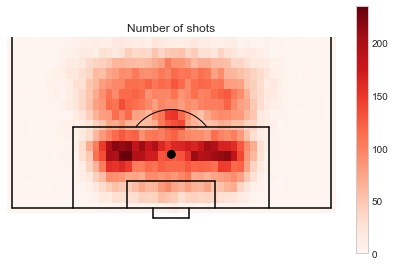

In [55]:
# Plot the number of shots from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto', cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/NumberOfShots.pdf', dpi=None, bbox_inches="tight")   

##### Number of shots

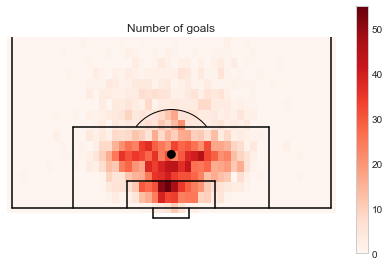

In [56]:
# Plot the number of GOALS from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto', cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/NumberOfGoals.pdf', dpi=None, bbox_inches="tight")  

##### Frequency of Scoring
Dividing the number of goals by the number of shots.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


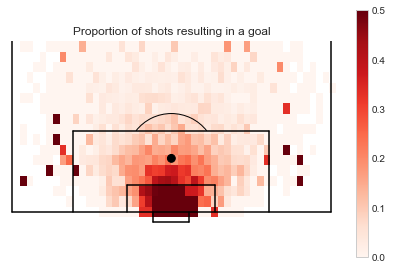

In [57]:
# Plot the probability of scoring from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto', cmap=plt.cm.Reds, vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight")   

In [ ]:
df_np_shots['xG']

In [ ]:
pitch_length_x = 104
pitch_length_y = 68

In [ ]:
# Add new columns

## Convert Understats coordinates from 0, 100 to a range of x(0,104) and y(0,68) - the average pitch size.
df_np_shots['XM'] = df_np_shots['start_x_norm'] * pitch_length_x
df_np_shots['YM'] = df_np_shots['start_y_norm'] * pitch_length_y

## Create reverse columns of previous created 'XM' and 'YM' columns
df_np_shots['XM_r'] = pitch_length_x - df_np_shots['XM']    # Added for completeness but not used
# ['YM_r'] = pitch_length_y - df_np_shots['YM']

## Create column of scaled xG to make them larger in the plot
#df_np_shots['xG_s'] = df_np_shots['xG'] * 1.5

In [ ]:
df_np_shots

In [ ]:
# Plotting Shots

## Draw the pitch
draw_pitch("#195905", "#faf0e6", "vertical", "half")


## X and Y coordinates
x = df_np_shots['XM'].tolist()
y = df_np_shots['YM'].tolist()
y1 = [68 - i for i in y]


## Add Z variable for xG
#z = df_np_shots['xG'].tolist()
#z1 = [500 * i for i in z] # This is to scale the "xG" values for plotting


## Add small legend in the bottom corner
#mSize = [0.05,0.10,0.2,0.4,0.6,1]
#mSizeS = [500 * i for i in mSize]
#mx = [5.5,7,9,11,13.5,16.5]
#my = [60,60,60,60,60,60]

plt.text(11, 55, "xG", color="white", ha="center", va="center", zorder=zo, fontsize=16)
plt.scatter(y1,
            x,
           #s=z1,
            c="red",
            edgecolors="k",
            zorder=zo
           )
# plt.scatter(mx, my, s=mSizeS, facecolors="white", edgecolor="white", zorder=zo)
plt.plot([5.5,17], [57,57], color="white",lw=2,zorder=zo)

i = 0

#for i in range(len(mx)):
#    plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color="#195905", zorder=zo,ha="center", va="center")

    
## Title
plt.title("Wyscout Shots 17/18 Season")

## Show plot
plt.show()

### <a id='#section4.6'>4.6. Convert Coordinates</a>
Standardise to the same coordinate system 105*68

In [ ]:
pitch_wyscout = Pitch(pitch_type='wyscout', orientation='vertical', view='half')

In [ ]:
# wyscout
df_np_shots[['x', 'end_x']] = ((df_np_shots[['x', 'end_x']]) / float(pitch_wyscout.right) * 105.)
df_np_shots[['y', 'end_y']] = ((float(pitch_wyscout.bottom) - df_wyscout_shots[['y', 'end_y']])  / float(pitch_wyscout.bottom)  * 68.)

### <a id='#section4.6'>4.6. Plot the shots</a>

In [ ]:
from mplsoccer.pitch import Pitch

In [ ]:
plt.style.use('dark_background')
pitch = Pitch(pitch_type='', figsize=(8, 9), view='half', line_zorder=3,
              constrained_layout=True, tight_layout=False, orientation='vertical')
fig, ax = pitch.draw()
pitch.scatter(df_np_shots.start_x, df_np_shots.start_y, ax=ax, c='#6ae4cd',
              label=f'Not in StatsBomb open-data ({len(df_np_shots)} shots)')
pitch.scatter(df_np_shots.start_x, df_np_shots.start_y, ax=ax, c='#e8d247',
              label=f'Not in Wyscout open-data ({len(df_np_shots)} shots)')
ax.legend(fontsize=15, loc='lower center',)
#fig.savefig(os.path.join('..', 'figures', '12_overlap_shot_differences.png'), bbox_inches = 'tight', pad_inches = 0.2)

### <a id='#section4.6'>4.6. Normalise the location features</a>
In order to help the learning algorithm, we rescale the location features from their original scales to a normalized scale ranging from 0 to 1. More specifically, we divide the x coordinates by 105 and the y coordinates by 68.

In [ ]:
df_np_shots['start_x_norm'] = df_np_shots['start_x'] / 105
df_np_shots['start_y_norm'] = df_np_shots['start_y'] / 68
df_np_shots['end_x_norm'] = df_np_shots['end_x'] / 105
df_np_shots['end_y_norm'] = df_np_shots['end_y'] / 68

In [ ]:
# Save Non-Penalty shots DataFrame if doesn't already exist
if not os.path.exists(data_dir_wyscout + '/engineered/combined/spadl/np_shots.csv'):
    df_np_shots.to_csv(data_dir_wyscout + '/engineered/combined/spadl/np_shots.csv', index=None, header=True)  
else:
    df_np_shots = pd.read_csv(data_dir_wyscout + '/engineered/combined/spadl/np_shots.csv')  

In [ ]:
# Display DataFrame
df_np_shots

---

## <a id='#section5'>5. Feature Engineering</a>
In order to predict the outcome of each shot, we need to transform our shots database into a dataset that we can fed into our machine learning algorithm. To this end, we perform the following three steps:

1. We compute the Eucledian distances between the start locations of each of the three actions and the center of the opposing goal. We add these three distances as features to our dataset as we expect them to help our machine learning algorithm to learn a more accurate model.

2. We construct our dataset by selecting a subset of the available features.

3. We split the dataset into a train set for training the model and a hold-out test set for evaluating the model. This is an important step as we aim to learn a predictive model that generalizes well to unseen examples. By evaluating our model on a hold-out test set, we can investigate whether we are overfitting on the train data.

### <a id='#section5.1'>5.1. Compute additional features</a>
We compute the Eucledian distances between the start location of each of the three actions and the center of the opposing goal, which is located at coordinates (1, 0.5) in our normalised coordinate representation.

In [ ]:
# Normalised location for the center of the opposing goal
goal = (1, 0.5)

In [ ]:
# Define the three key actions
df_np_shots['start_distance'] = df_np_shots.apply(lambda s: distance.euclidean((s['start_x_norm'], s['start_y_norm']), goal), axis=1)

### <a id='#section5.2'>5.2. Construct the dataset</a>
We construct our dataset by selecting a subset of the available features. In this how-to, we use a limited number of features such as the location of the shot (`action_start_x` and `action_start_y`), the body part used by the shot taker (`action_body_part_id`), and the distances between the locations of the three actions and the center of the opposing goal (`action_start_distance`, `action1_start_distance`, and `action2_start_distance`).

We encourage you to try other features as well and to investigate what effect they have on the performance of your expected-goals model. For example, you could try to include the angle between the shot location and the center of the goal or the angle between the shot location and the goal posts as a feature too. 

In [ ]:
df_np_shots

In [ ]:
# Features
columns_features = ['start_x_norm', 'start_y_norm', 'bodypart_id', 'start_distance']

# Label: 1 if a goal, 0 otherwise
column_target = 'result_id'

In [ ]:
X = df_np_shots[columns_features]
y = df_np_shots[column_target]

### <a id='#section5.3'>5.3. Split the dataset into a train set and a test set</a>
We train our expected-goals model on 90% of the data and evaluate the model on the remaining 10% of the data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

---

## <a id='#section6'>6. Machine Learning Modelling</a>
We learn our expected-goals model using the XGBoost algorithm, which is a popular algorithm in machine learning competitions like Kaggle. The algorithm is particularly appealing as it requires minimal parameter tuning to provide decent performance on many standard machine learning tasks.

For more information about XGBoost, see the official docs [[link](http://xgboost.readthedocs.io/en/latest/model.html)].

### <a id='#section6.1'>6.1. Option 1: Train an XGBoost classifier using manually set hyperparameters</a>
We train an XGBoost classifier on our train set. We train 100 trees and set their maximum depth to 5.

In [ ]:
classifier = XGBClassifier(objective='binary:logistic', max_depth=5, n_estimators=100)
classifier.fit(X_train, y_train)

### <a id='#section6.2'>6.2. Option 2: Train an XGBoost classifier using grid search to automatically optimize the hyperparameters</a>
We train an XGBoost classifier on our train set by performing a grid search over a set of reasonable hyperparameters to find the optimal hyperparameters for this task. We vary the maximum depths of the trees from 3 to 6 and try learning 100, 500, and 1000 trees. We use the default three-fold cross-validation approach to find the best set of hyperparameters.

We encourage you to explore different values for the hyperparameters as well. The following page offers an overview of the hyperparameters that can be tuned: [XGBoost Parameters](http://xgboost.readthedocs.io/en/latest/parameter.html). 

In [ ]:
parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01],
    'n_estimators': [100, 500, 1000],
    'seed': [42]
}

classifier = XGBClassifier()
classifier = GridSearchCV(classifier, parameters, scoring='roc_auc', verbose=2)
classifier.fit(X_train, y_train)

In [ ]:
# Print out the XGBoost model metrics
print("---XGBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

### <a id='#section6.3'>6.3. Option 3: Train an CatBoost classifier</a>
[CatBoost](https://catboost.ai/) is a state-of-the-art, open-source gradient boosting on-decision trees library created by [Yandex](https://yandex.com/).

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

The [CatBoost Python tutorial on GitHub](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb) uses the the Titanic Dataset and has some great tricks to improve the results in this notebook. [Anna Veronika Dorogush](https://www.linkedin.com/in/anna-veronika-dorogush-08739637/) has also presented [Mastering gradient boosting with CatBoost](https://www.youtube.com/watch?v=usdEWSDisS0) lecture at [PyData 2019 London](https://pydata.org/london2019/) explaining more about CatBoost and how it works.

In [ ]:
X_train

In [ ]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

This means Catboost has picked up that all variables except `Fare` can be treated as categorical.

In [ ]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [ ]:
y_train.head()

In [ ]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

##### Perform CatBoost cross-validation

In [ ]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

In [ ]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---

## <a id='#section7'>7. Model Evaluation</a>
We evaluate the accuracy of our xG model by making predictions for the shots in our test set.

### <a id='#section7.1'>7.1. Predict the test examples</a>

In [ ]:
# For each shot, predict the probability of the shot resulting in a goal
y_pred = classifier.predict_proba(X_test)

### <a id='#section7.2'>7.2. Compute area under the curve: receiver operating characteristic (AUC-ROC)</a>
To measure the accuracy of our expected-goals model, we compute the AUC-ROC obtained on the test set. The values for the AUC-ROC metric range from 0 to 1. The higher the AUC-ROC value is, the better the classifier is, where an AUC-ROC value of 0.50 corresponds to random guessing. That is, if we randomly predicted whether a shot results in a goal or not, we would obtain an AUC-ROC of 0.50.

In [ ]:
y_total = y_train.count()
y_positive = y_train.sum()

print('The training set contains {} examples of which {} are positives.'.format(y_total, y_positive))

In [ ]:
auc_roc = roc_auc_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))

### <a id='#section7.3'>7.3. Compute area under the curve: precision-recall (AUC-PR)</a>
Since the AUC-ROC metric is susceptible to class imbalance (i.e., the number of positive examples is much lower or higher than the number of negative examples), we also compute the AUC-PR obtained on the test set. The values for the AUC-PR metric range from 0 to 1 too. The higher the AUC-PR value is, the better the classifier is. Unlike AUC-ROC, however, the value for random guessing does not necessarily correspond to 0.50 for imbalanced classes, but corresponds to the ratio of positive examples in the train set.

In [ ]:
auc_pr_baseline = y_positive / y_total

print('The baseline performance for AUC-PR is {}.'.format(auc_pr_baseline))

In [ ]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))

### <a id='#section7.4'>7.4. Plot AUC-ROC curve</a>

In [ ]:
plot_roc_curve(y_test, y_pred, curves='each_class')

### <a id='#section7.5'>7.5. Plot AUC-PR curve</a>

In [ ]:
plot_precision_recall_curve(y_test, y_pred, curves='each_class')

### <a id='#section7.6'>7.6. Plot Calibration curve</a>
We plot a calibration curve to investigate how well our expected-goals model is calibrated. The plot shows the mean predicted value on the horizontal axis and the fraction of covered positive examples on the vertical axis.

In [ ]:
plot_calibration_curve(y_test, [y_pred])

---

## <a id='#section8'>8. Summary</a>
This notebook is a short walkthrough of the process for building a simple Expected Goals model that produces an Expected Goals value for each shot that happened during a game of football. Our how-to is available as a Jupyter notebook and showcases some of the tools and technologies our data analytics team uses to build their analytics models and metrics.

---

## <a id='#section9'>9. Next Steps</a>
The step is to ...

---

## <a id='#section11'>10. References</a>
*    [Tom Decroos](https://twitter.com/TomDecroos), [Lotte Bransen](https://twitter.com/LotteBransen), [Jan Van Haaren](https://twitter.com/JanVanHaaren), and [Jesse Davis](https://twitter.com/jessejdavis1). [Actions Speak Louder than Goals: Valuing Player Actions in Soccer](https://arxiv.org/abs/1802.07127). In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
*    Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. "[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)" *Scientific Data 6*, no. 1 (2019): 1-15.(https://www.nature.com/articles/s41597-019-0247-7). Scientific Data 6, no. 1 (2019): 1-15.
*    [Tech how-to: build your own Expected Goals model by SciSports](https://www.scisports.com/tech-how-to-build-your-own-expected-goals-model/)

---

## <a id='#section11'>11. Further Reading</a>
*    [The Future of Stats: xG, xA by Tifo Football Podcast](https://www.youtube.com/watch?v=sNCeA27sDvI)
*    [What is xG? YouTube video by Tifo Football](https://www.youtube.com/watch?v=zSaeaFcm1SY)
*    What are Expected Assists? YouTube video by Tifo Football](https://www.youtube.com/watch?v=1MdlkuzLdj4)
<br>

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)